In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Problem 3: Framingham Heart Study

## 3a)

In [2]:
train = pd.read_csv("framingham_train.csv")
test = pd.read_csv("framingham_test.csv")

train.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,59,Some college/vocational school,0,0,0,0,1,0,285,128.0,91.0,28.23,70,80,0
1,0,43,High school/GED,1,15,1,0,1,0,172,149.0,82.0,22.35,60,64,0
2,0,48,Some high school,0,0,0,0,1,0,275,177.0,101.0,25.22,75,82,1
3,0,52,Some college/vocational school,0,0,0,0,0,0,272,112.5,75.5,22.69,90,83,0
4,0,38,High school/GED,1,5,0,0,0,0,179,116.5,72.5,21.49,70,76,0


### 3a) i)

In [3]:
logistic = smf.logit(formula = 'TenYearCHD ~ male + age + education + currentSmoker + cigsPerDay + BPMeds + \
                                prevalentStroke + prevalentHyp + diabetes + totChol + sysBP + diaBP + BMI + \
                                heartRate + glucose', data = train).fit()
print(logistic.summary())

Optimization terminated successfully.
         Current function value: 0.371879
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2560
Model:                          Logit   Df Residuals:                     2542
Method:                           MLE   Df Model:                           17
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.1102
Time:                        15:04:29   Log-Likelihood:                -952.01
converged:                       True   LL-Null:                       -1069.9
Covariance Type:            nonrobust   LLR p-value:                 1.627e-40
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

Thus, my fitted logistic regression model is:

$$ y = P(TenYearCHD = 1|X) = \frac{1}{(1+e^{-c})} $$

where $$ c = -8.0533 + 0.0041 * education[High school/GED] + 0.1267 * education[College/vocational school] + 0.1930 * education[High school] + 0.5124 * male + 0.0637 * age + 0.0608 * curerntSmoker + 0.0190 * cigsPerDay + 0.1631 * BPMeds + 0.7908 * prevalentStroke + 0.2797 * prevalentHype - 0.0086 * diabetes + 0.0027 * totChol + 0.0133 * sysBP - 0.0066 * diaBP + 0.0150 * BMI - 0.0056 * heartRate + 0.0054 * glucose $$

### 3a) ii)

The most important risk factors are those with small p-values (lower than $0.05$). Based on the summary, it is clear that gender (male), age, cigsPerDay, sysBP, totChol, and glucose are significant. One of the most important factors, gender, says that if you are a male, you have a higher risk of developing coronary heart disease. Based on the equation, if someone is assigned male, then he has $ e^{0.5124} $ (or $1.669$) increased odds of CHD in the next 10 years.

### 3a) iii)

Based on Figure 1, I can derive the following equations:

Loss from prescribing medication = $1,050,000 * 0.1p + 95,000 * (1 - 0.1p)$

Loss from no medication = $955,000p$

Then, by following Bayes' decision rule and setting the equations equal to each other, I get:
$$ 1,050,000 * 0.1p + 95,000 * (1 - 0.1p) = 955,000p$$
$$ 105,000p + (95,000 - 9,500p) = 955,000p $$
$$ 95,500p + 95,000 = 955,000p $$
$$ 95,000 = 859,500p $$

Thus, $\overline{p} = 0.1105$. Which means that it is optimal to prescribe a patient medication only if their risk exceeds $0.1105$.

### 3a) iv)

In [4]:
p = 95000 / 859500
y_test = test['TenYearCHD']
y_prob = logistic.predict(test)
y_pred = pd.Series([1 if x > p else 0 for x in y_prob], index = y_prob.index)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[495 423]
 [ 31 149]]


In [5]:
accuracy = (cm.ravel()[0] + cm.ravel()[3]) / sum(cm.ravel())
tpr = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])
fpr = cm.ravel()[1] / (cm.ravel()[1] + cm.ravel()[0])
print("Accuracy:", accuracy)
print("True Positive Rate", tpr)
print("False Positive Rate", fpr)

Accuracy: 0.5865209471766849
True Positive Rate 0.8277777777777777
False Positive Rate 0.46078431372549017


The accuracy in a model is the proportion of patients that were correctly classified (i.e. classified positive if you had CHD or classified negative if you didn't). The true positive rate is the proportion of patients with CHD that were correctly identified as positive. The false positive rate is the proportion of non-CHD patients that were incorrectly identified as postive. 

Based on these definitions, my model correctly predicts $58.65$% of the population's CHD conditions. Among those who actually develop CHD, my model can corerctly identify $82.78%$% of them. Finally, among those who don't develop CHD, my model would incorreclty classify $46%$% as having CHD.

### 3a) v)

My model's expected cost is:
$$ 1,050,000 * tpr + 95,000 * fpr + 955,000 * fnr $$

In [6]:
ec = 1050000 * 149 + 95000 * 423 + 955000 * 31
print("Total expected cost:", ec)
print("Total expected cost per patient is:", ec/1098)

Total expected cost: 226240000
Total expected cost per patient is: 206047.35883424408


This expected cost was under the assumption that the treatment decision doesn't affect the CHD outcomes. However, this assumption is unreasonable because if the treatment does have an effect, the cost will not be the one above. If the medication works, I can assume that 90% of the true positives wouldn't develop CHD. Under this assumption that treatment decision does impact patient risk, the new expected cost is:

$$ 1,050,000 * (0.1 * tpr) + 95,000 * (fpr + 0.9 * tpr) + 955,000 * fnr $$

In [7]:
nec = 1050000 * 149 * 0.1 + 95000 * (423 + 0.9 * 149) + 955000 * 31
print("New expected cost:", nec)
print("The new expected cost per patient is:", nec/1098)

New expected cost: 98174500.0
The new expected cost per patient is: 89412.11293260474


### 3a) vi)

In [8]:
cm_baseline = confusion_matrix(test['TenYearCHD'], [0] * test.shape[0])
print("Confusion Matrix for baseline model: \n", cm_baseline)

Confusion Matrix for baseline model: 
 [[918   0]
 [180   0]]


In [9]:
accuracy_base = (cm_baseline.ravel()[0] + cm_baseline.ravel()[3]) / sum(cm_baseline.ravel())
tpr_base = cm_baseline.ravel()[3] / (cm_baseline.ravel()[3] + cm_baseline.ravel()[2])
fpr_base = cm_baseline.ravel()[1] / (cm_baseline.ravel()[1] + cm_baseline.ravel()[0])
print("Baseline Accuracy:", accuracy_base)
print("Baseline True Positive Rate", tpr_base)
print("Baseline False Positive Rate", fpr_base)

Baseline Accuracy: 0.8360655737704918
Baseline True Positive Rate 0.0
Baseline False Positive Rate 0.0


In [10]:
baseline_ec = 955000 * 180
print("The baseline expected cost per patient is:", baseline_ec/1098)

The baseline expected cost per patient is: 156557.37704918033


The accuracy for this baseline model is noticeably higher than my previous model. However, the reason for this improvement is because the baseline model doesn't classify anything as positive (setting the fpr at 0). Thus, the model won't identify potential CHD patients (making tpr 0). 

Since the cost of wrongly identifying a positive sample as negative is much higher than the reverse, the baseline model, despite its increased accuracy, has much higher expected costs per patient.

### 3a) vii)

In [11]:
patient = pd.DataFrame(data = {'education': ['High school/GED'], 'male': [0], 'age': [39], 'currentSmoker': [1], \
                               'cigsPerDay': [6], 'BPMeds': [0], 'prevalentStroke': [0], 'prevalentHyp': [0], \
                              'diabetes': [1], 'totChol': [230], 'sysBP': [110], 'diaBP': [50], 'BMI': [28], \
                              'heartRate': [72], 'glucose': [80]})
logistic.predict(patient)

0    0.039055
dtype: float64

Based on this patient's medical records, they have a probability of $0.039055$ of developing CHD. Given that $\overline{p} = 0.1105$ and this patient's risk is below the threshold, the physician should not prescribe this patient with medication.

## 3b)

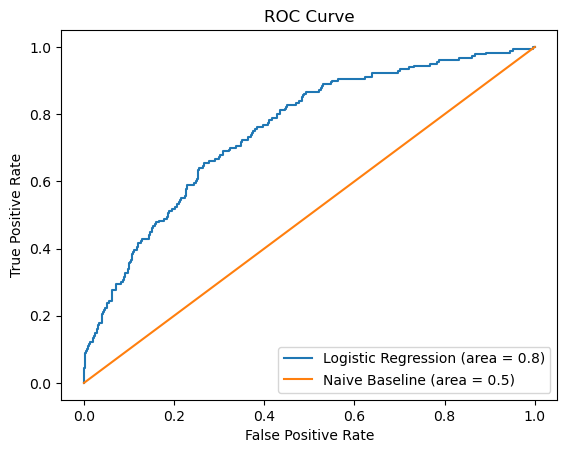

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Logistic Regression (area = {:0.1f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], label = 'Naive Baseline (area = 0.5)')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The ROC curve is helpful because it demonstrates the trade off between the true and false positive rate. This allows you to choose the best threshold for your model, by balancing the costs associated of the true positive and false positives. In this specific example, given that the loss for a false positive is much lower than the cost for a true positive, it is optimal to choose a cut-off where the tpr is high (left upper area).

One interesting observation is that the ROC curve is well above the baseline. This means that my model outperforms the baseline model. The $0.83$ tpr, $0.46$ fpr, and their position relative to the basline indicates the model has good performance and discriminative ability.

## 3c)

Loss from prescription = $(C + 625,000) * 0.1p + C * (1 - 0.1p)$

Loss from no prescription = 625,000p

Then, by following Bayes' decision rule and setting the equations equal to each other, I get:
$$ (C + 625,000) * 0.1p + C * (1 - 0.1p) = 625,000p $$
$$ 0.1Cp + 62,500p + C - 0.1Cp = 625,000p $$
$$ C = 562,500p $$

Finally, by plugging in the $\overline{p}$ from 3a), I get:
$$ C = 562,500(0.1105) $$
$$ C = 62,156.25 $$

Thus, the insurance company should charge $ 62,156.25 $ as a copayment in order for the patients to be able to "self select" in the "optimal strategy."

## 3d)

One ethical concern to raise is the value of human life. Different people, at different stages, states in their lives, value their life differently. A healthy person may value their life differently to a chronically ill person, a person struggling with mental disability may unjustly devalue their life. But, someone who is always positive and healthy, and happy, may believe their life is priceless. Thus, quantifying the decreased quality of life at $625,000 is not correct and morally questionable. 

One way to to perform analysis to address this concern is to allow the person themselves, (or perhaps a guardian) to select the assumptions of their own life and allow them to set the threshold and cutoff values to make their decisions.